# Hetroscedastic Gaussian Processes

Gaussian Processes for quantifying the risk associated with taking an action. 

In [1]:
import baestorm
import GPy
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyswmm_lite import environment
from functools import partial

In [2]:
plt.style.use('seaborn-white')
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['font.size'] = 14.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y
gaussian_flows = np.vectorize(gaussian_flows)

In [4]:
means = [0.0]
sigma = np.linspace(2.0, 5.0, 10)
scale = 5.0

inflows = {}
count = 0
for mu in means:
    for sig in sigma:
        inflows[str(count)] = scale * gaussian_flows(np.linspace(-10.0, 10.0, 100), mu, sig)
        count += 1
inflows = pd.DataFrame.from_dict(inflows)

Text(0, 0.5, 'Flow')

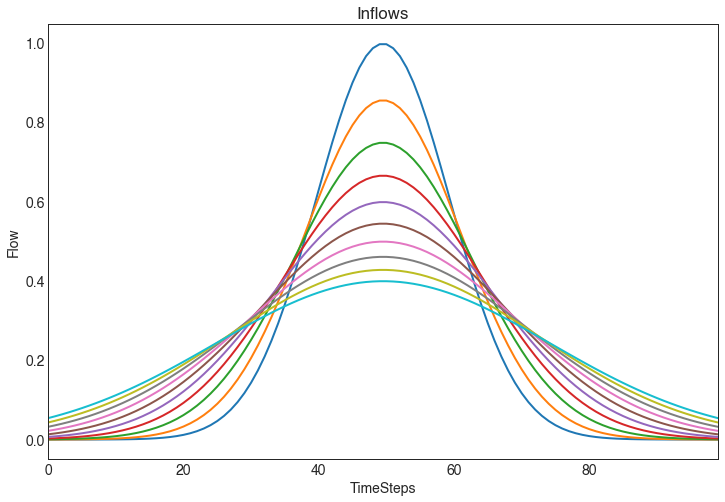

In [5]:
ax = inflows.plot(legend=False, title="Inflows")
ax.set_xlabel("TimeSteps")
ax.set_ylabel("Flow")

In [6]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)
    data = {}
    data["outflow"] = []
    data["overflow"] = []
    data["depth"] = []
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(300))
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)
        # set inflow
        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)
        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))
        data["depth"].append(env._getNodeDepth("P1"))
        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"]), data["depth"]

In [7]:
data_flows = {}
for i in inflows.keys():
    flows, overflow, depth  = single_basin(1.0, inflows[i].values)
    data_flows[i] = flows
data_flows = pd.DataFrame.from_dict(data_flows)

Text(0, 0.5, 'Outflow')

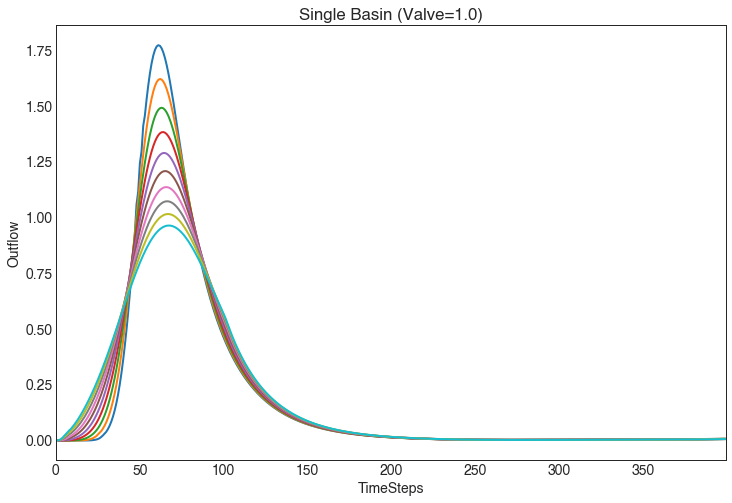

In [8]:
ax = data_flows.plot(legend=False, title="Single Basin (Valve=1.0)")
ax.set_xlabel("TimeSteps")
ax.set_ylabel("Outflow")

In [9]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, 9, 10, dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows, depth = single_basin(valves, inflows[str(temp_1)].values)
    # If completely closed, then penalize on depth
    threshold=0.50
    # IF flows exceed threhold, penalize based on the diviation
    flows = pd.Series(flows)
    flows_sub = flows.sub(threshold)
    flows_sub[flows_sub < 0.0] = 0.0
    if flows.sum() == 0.0:
        flow_ration = 0.0
    else:
        flow_ration = flows_sub.sum()/flows.sum()
    reward = np.exp(overflows/inflows[str(temp_1)].sum() + flow_ration + depth[-1]/2.0) - 1.0
    return reward

In [10]:
actions = np.linspace(0.0, 1.0, 200)
reward = np.zeros((30, 200))
for action in range(0, 200):
    for rainevent in range(0, 30):
        reward[rainevent, action] = objective_function(actions[action].reshape(-1,1))

Text(0.5, 1.0, 'Objective Function')

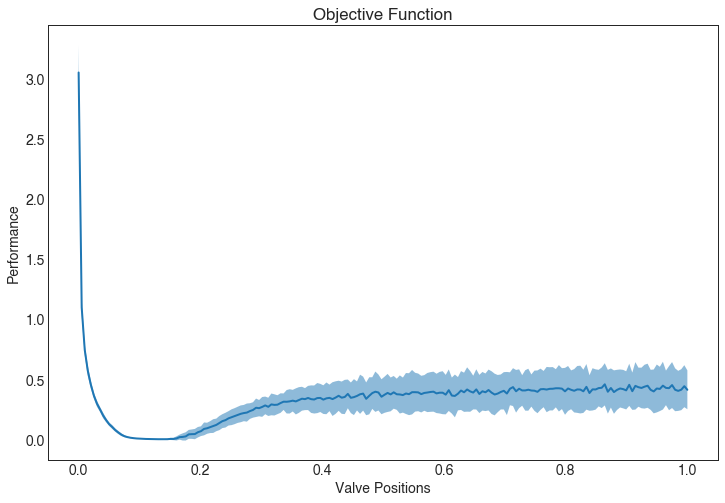

In [11]:
m = reward.mean(axis=0)
std = np.std(reward, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)
plt.xlabel("Valve Positions")
plt.ylabel("Performance")
plt.title("Objective Function")

In [12]:
x = []
y = []
val = np.linspace(0.0,1.0,200)
for i in range(0, 200):
    x_t = np.array(np.random.rand()) # random action between 0 to 1
    y_t = objective_function(x_t.reshape(-1,1))
    x.append(x_t)
    y.append(y_t)

In [13]:
y = np.array(y)
x = np.array(x)

Text(0.5, 1.0, 'Normalized Data')

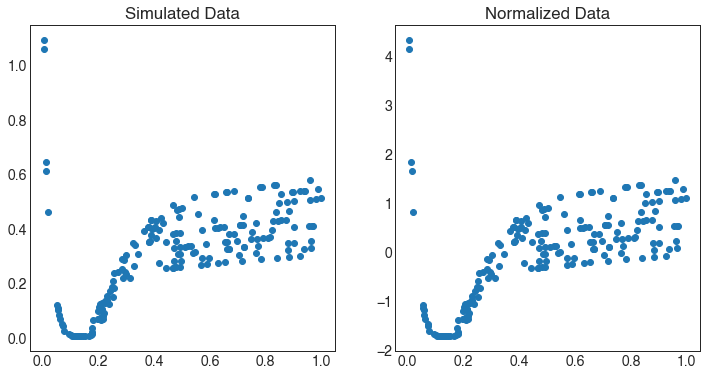

In [14]:
plt.rcParams["figure.figsize"] = (12,6)
plt.subplot(1,2,1)
plt.plot(x, y, 'o')
plt.title("Simulated Data")
plt.subplot(1,2,2)
y = (y - y.mean())/y.std()
plt.plot(x, y, 'o')
plt.title("Normalized Data")

## Vanilla - Gaussian Processes 

VGP uses an uniform covariance. It is estimated by minimizing MLE.

In [16]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x.reshape(-1,1), y.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 142.61501349708672
Optimization restart 2/10, f = 142.61501352764947
Optimization restart 3/10, f = 142.61501349650072
Optimization restart 4/10, f = 142.61501350035104
Optimization restart 5/10, f = 142.61501350087633
Optimization restart 6/10, f = 142.61501349649797
Optimization restart 7/10, f = 142.61501349659778
Optimization restart 8/10, f = 142.61501349650163
Optimization restart 9/10, f = 142.61501350754844
Optimization restart 10/10, f = 142.6150141296854


Text(0.5, 1.0, 'Objective Function')

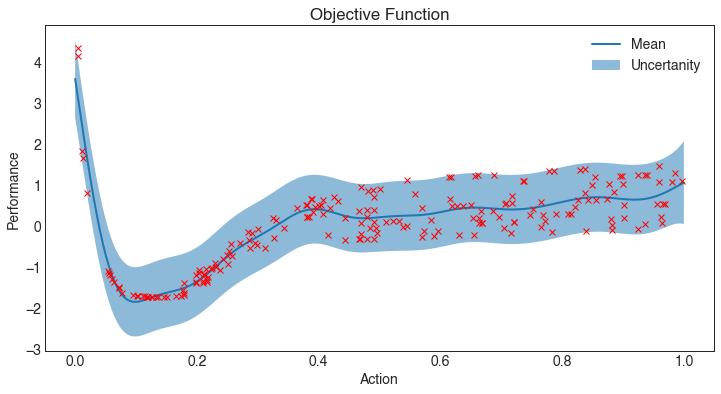

In [19]:
# Plot error bounds
x_test = np.linspace(0.0,1.0, 200)
m, v = vgp.predict(x_test.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x_test, up, dwn, alpha=0.5, label="Uncertanity")
plt.plot(x_test, m, label="Mean")
plt.plot(x,y,'x',color='red')
plt.legend()
plt.ylabel("Performance")
plt.xlabel("Action")
plt.title("Objective Function")

## Hetroscadastic Gaussian Processes

In [60]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 142.61501349708672
Optimization restart 2/5, f = 142.6150134965335
Optimization restart 3/5, f = 142.61501349653912
Optimization restart 4/5, f = 142.6150134978613
Optimization restart 5/5, f = 142.61501349705233


In [61]:
m, v = gp1.predict(x.reshape(-1,1))
s = 25
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

Text(0.5, 1.0, 'Noise Mean Estimate')

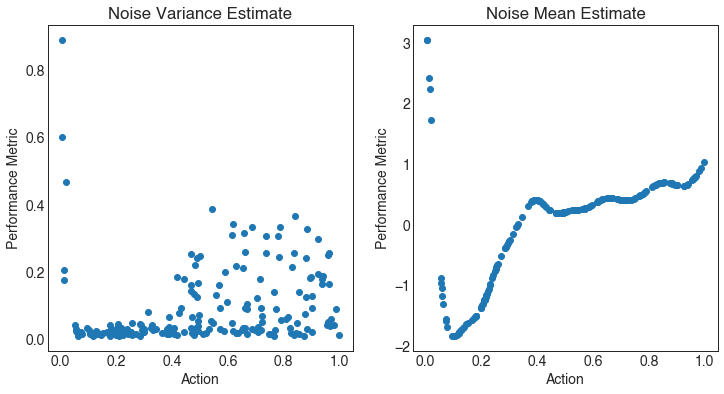

In [62]:
plt.subplot(1,2,1)
plt.plot(x, variance_noise,'o')
plt.xlabel("Action")
plt.ylabel("Performance Metric")
plt.title("Noise Variance Estimate")
plt.subplot(1,2,2)
plt.plot(x, m,'o')
plt.xlabel("Action")
plt.ylabel("Performance Metric")
plt.title("Noise Mean Estimate")

In [63]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 10)
m_n, v_n = gp2.predict(x.reshape(-1,1))

Optimization restart 1/10, f = 272.9126305609068
Optimization restart 2/10, f = 272.9126305598721
Optimization restart 3/10, f = 273.8955689227282
Optimization restart 4/10, f = 272.9126305645067
Optimization restart 5/10, f = 273.89556896457054
Optimization restart 6/10, f = 272.9126306094293
Optimization restart 7/10, f = 272.9126305988293
Optimization restart 8/10, f = 273.8955689226472
Optimization restart 9/10, f = 272.9126305647082
Optimization restart 10/10, f = 273.89556892315653


In [64]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -89.80204672444987
Optimization restart 2/10, f = -85.09183716240099
Optimization restart 3/10, f = -80.4142139522987
Optimization restart 4/10, f = -84.45765315768179
Optimization restart 5/10, f = -86.4805294101256
Optimization restart 6/10, f = -80.67103716793301
Optimization restart 7/10, f = -84.82039474624557
Optimization restart 8/10, f = -73.25496759749305
Optimization restart 9/10, f = -89.42917431873914
Optimization restart 10/10, f = -90.2758240666544


In [65]:
kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

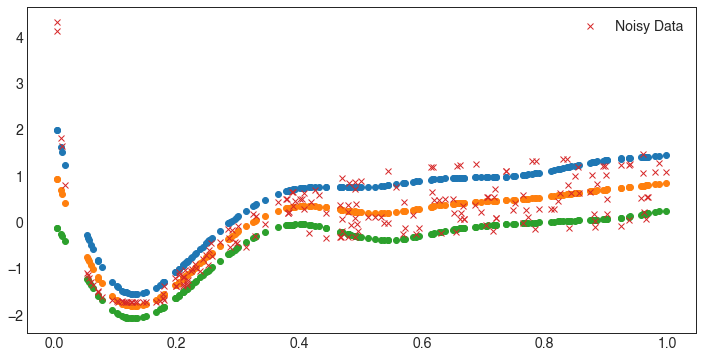

In [66]:
m, v = gp3.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x, up, 'o')
plt.plot(x, m, 'o')
plt.plot(x, dwn, 'o')
plt.plot(x, y, 'x', label="Noisy Data")
plt.legend()

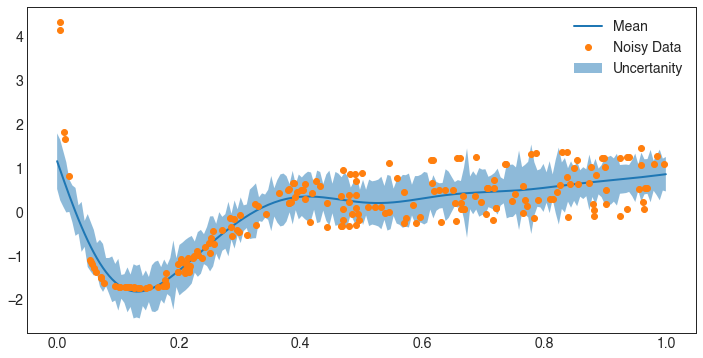

In [67]:
x_t = np.linspace(0.0, 1.0, 200)
m, v = gp3.predict(x_t.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.fill_between(x_test, up, dwn, alpha=0.5, label="Uncertanity")
plt.plot(x_test, m, label="Mean")
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

In [59]:
gp1 = copy.deepcopy(gp3)

Rather than using a white noise kernel, having a static kernel might be better.